Preperation
We first start with imports,

In [1]:
import torch
from odak.learn.wave import calculate_phase, calculate_amplitude, wavenumber, propagate_beam, produce_phase_only_slm_pattern, set_amplitude, generate_complex_field, linear_grating
from odak.learn.tools import zero_pad, crop_center, save_image,load_image
from odak import np
from tqdm import tqdm

Let's define our wavelength for our light source and calculate wavenumber.

In [2]:
wavelength = 515e-9
k = wavenumber(wavelength)

Pixel pitch and resolution of the phase-only hologram or a phase-only spatial light modulator that we are simulating:

In [3]:
dx = 0.000008
resolution = [1080,1920]

Define the deired distance that the optical reconsturction will form away from the optimized phase pattern.

In [4]:
distance = 0.15

We need to set a target image that we want to reconstruct in a holographic display. Either we can load a sample image here or create a white square on a black background like in this example.

In [5]:
square_size = 100
target = torch.zeros(resolution[0],resolution[1])
target[round((resolution[0]-square_size)/2):round((resolution[0]+square_size)/2),round((resolution[1]-square_size)/2):round((resolution[1]+square_size)/2)] = 1.

Lets visualize the target image to see what we have compiled so far:

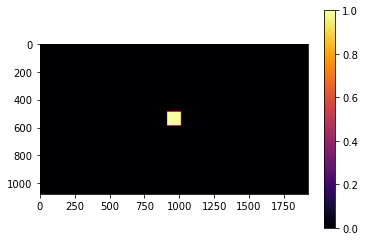

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.imshow(target, cmap=cm.inferno)
plt.colorbar()
plt.show()

In order simulate the travelling light we need to represent the light propagation in free space. There are different possibilities but In this example we will use transfer function Fresnel approach. 

In [7]:
propagation_type = 'TR Fresnel'

We nee to define our SLM's modulation and dynamic range. Depending on your SLM's calibration and dynamic range things may vary.

In [8]:
slm_range = 2*np.pi
dynamic_range = 255

We need number of iterarions.

In [9]:
iteration_number = 100
t = tqdm(range(iteration_number), leave=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Lets initiliaze our complex field at the hologram plane.

In [10]:
phase = torch.rand(resolution[0], resolution[1])
amplitude = torch.ones_like(target)
hologram = generate_complex_field(amplitude,phase)

## Gerchberg-Saxton Algorithm
Gerchberg-Saxton (GS) algorithm is an iterative phase retrival method which estimates the phase of an unknown complex-valued field from two intensity measurements that are acquired in two different planes. 
In the GS method, first, we start with a complex field with amplitude values equal to the computed wavefront pattern in the hologram plane and random initial phase values. First, we replace the amplitude of the complex field with the amplitude of the incoming light source, which is 1 if a collimated laser source is used. The complex field generated with these values is propagated to the reconstruction plane via wave propagation techniques. Later on the amplitude of the complex field in the reconstruction plane is again replaced with the desired target images amplitude values. This new complex field is back propagated to the hologram plane, where the amplitude and phase values are updated with respect to the applied wave propagation technique. This chain of processing is iteratively applied again and again until the reconstruction that is generated by the phase-only hologram is acceptable.  

In [11]:
for i in t:
	hologram = zero_pad(hologram)
	recon_field = propagate_beam(hologram, k, distance, dx, wavelength, propagation_type)
	recon_field = crop_center(recon_field) 
	recon_field = set_amplitude(recon_field,target)
	recon_field = zero_pad(recon_field)
	hologram = propagate_beam(recon_field, k, -distance, dx, wavelength, propagation_type)
	hologram = crop_center(hologram)
	hologram = set_amplitude(hologram, amplitude)

Now we have the optimized complex field for the hologram plane. In order to visulize the simulated result at the reconstruction plane we need to propagate the complex field to the reconstruction plane.  

In [12]:
hologram_padded = zero_pad(hologram)
reconstruction = propagate_beam(hologram_padded, k, distance, dx, wavelength, propagation_type)
reconstruction = crop_center(reconstruction)

Now we have simulated reconstruction available to us, lets save it as a image.

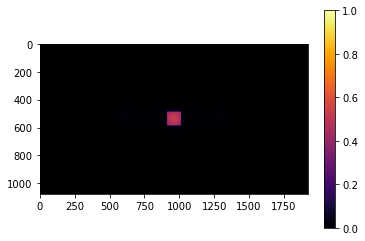

In [13]:
reconstruction_amp = calculate_amplitude(reconstruction)
reconstruction_intensity = (reconstruction_amp/reconstruction_amp.max())**2
save_image('reconstructed_image.png',reconstruction_intensity,cmin=0.,cmax=1.)

plt.imshow(reconstruction_intensity, cmap=cm.inferno)
plt.colorbar()
plt.show()

Now we can save our phase-only hologram.

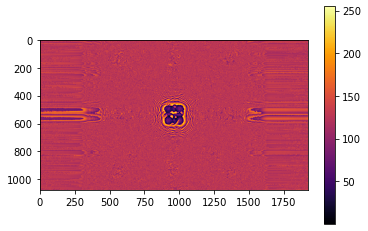

In [14]:
phase_hologram = calculate_phase(hologram)
phase_only_hologram = (phase_hologram%slm_range)/slm_range*dynamic_range
save_image('phase_only_hologram.png',phase_only_hologram)

plt.imshow(phase_only_hologram, cmap=cm.inferno)
plt.colorbar()
plt.show()

In some cases, you may want to add a grating term to your hologram as you will display it on a spatial light modulator. There are various reasons for that, but the most obvious is getting rid of zeroth-order reflections that are not modulated by your hologram. 

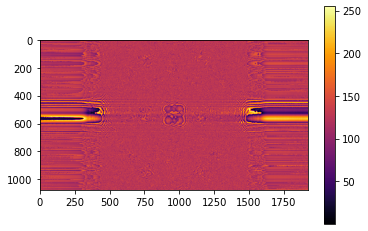

In [15]:
grating = linear_grating(resolution[0],resolution[1],axis='y').to(phase_hologram.device)
phase_only_hologram_w_grating = phase_hologram+calculate_phase(grating)
phase_only_hologram_w_grating = (phase_only_hologram_w_grating%slm_range)/slm_range*dynamic_range
save_image('phase_only_hologram_w_grating.png',phase_only_hologram_w_grating)

plt.imshow(phase_only_hologram_w_grating, cmap=cm.inferno)
plt.colorbar()
plt.show()